# A3 – AlexNET-VGG: CNN Variants (CPU-Only)¶
## CIFAR-10 | AlexNet-like vs VGG-style (from scratch)
### Starter Notebook

**Hardware assumption:** CPU-only laptops/PC for training
**Dataset:** CIFAR-10 (32×32 RGB, 10 classes)  
**Recommended settings:** `IMG_SIZE=(32,32)`, `BATCH_SIZE=64`, `EPOCHS=10–15`

**Learning goals**
- Implement two landmark CNN *styles* from scratch (AlexNet-like vs VGG-style)
- Compare **depth vs width**, **downsampling strategy**, **params vs accuracy**, and **training time**
- Perform a small **regularization mini-experiment** and **error analysis**


## Q0 — Setup (Ungraded)
Import libraries, set seeds, and check TensorFlow availability.

In [ ]:
import os, time, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))  # OK if empty on CPU


TensorFlow: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## ✅ Student Instructions (Start Here)

Your work begins in the **next code cells (Q1–Q8)** and continues by answering questions in the **Markdown cells (Q9–Q11)**. These correspond to the questions listed in the assignment description on Canvas. Complete each cell by following the instructions provided in the **preceding Markdown cells**.

Please:
- **Read the instructions carefully** before you begin coding.
- Take time to **understand each question** and implement the required steps.
- Each code cell includes **partial starter code**—your task is to **fill in the missing parts** and ensure the cell runs correctly.

If you need clarification at any point, please contact the **teaching staff (instructor/TA)** for support.


## Q1 — Load CIFAR-10 & Inspect (Warm-up)

Load CIFAR-10 using `tf.keras.datasets.cifar10.load_data()`.

Print:
- shapes of train/test
- number of classes
- show 12 sample images with labels


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
x_train: (50000, 32, 32, 3) y_train: (50000,)
x_test : (10000, 32, 32, 3) y_test : (10000,)
Num classes: 10


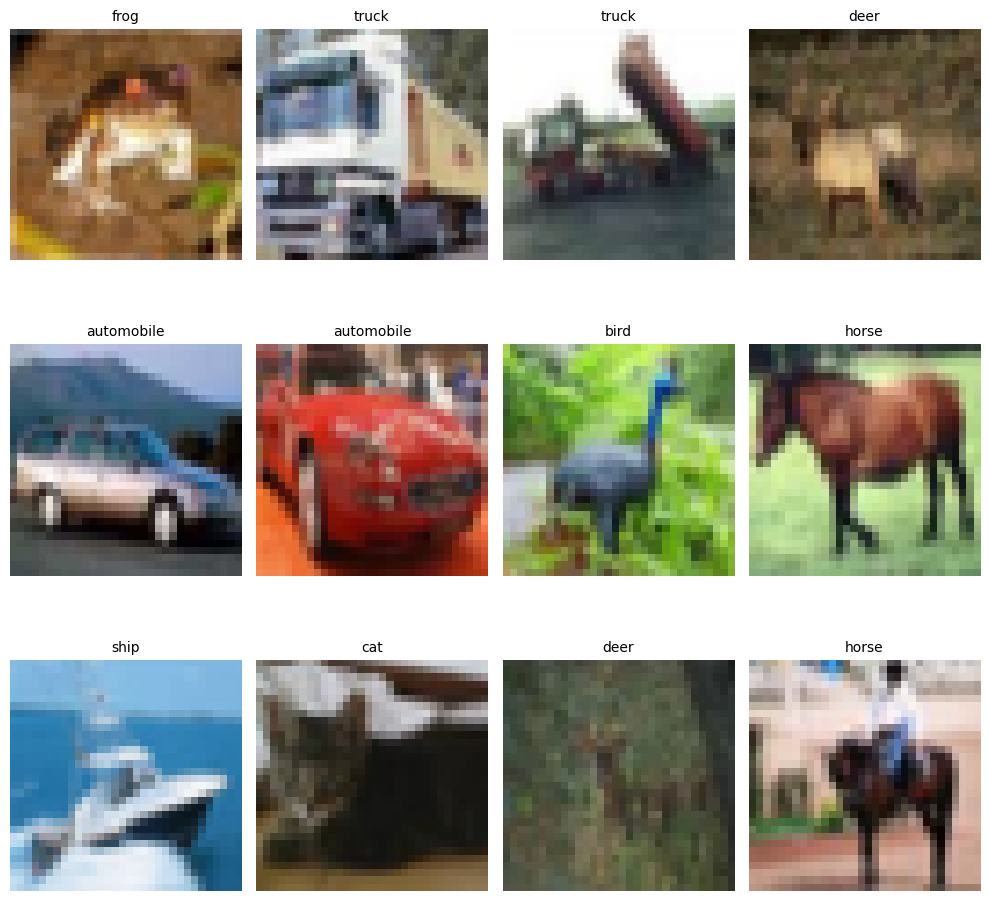

In [ ]:
# ============================================================
# Question Q1 — Load and Visualize CIFAR-10 (Fill in the Blanks)
# ============================================================
# Complete the TODO sections to:
#  1) Load CIFAR-10 using tf.keras.datasets
#  2) Fix label shapes (squeeze)
#  3) Define class names and number of classes
#  4) Print dataset shapes
#  5) Visualize 12 training images with correct class labels
# ============================================================

import tensorflow as tf
import matplotlib.pyplot as plt

# TODO 1: Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# TODO 2: Convert labels from shape (N,1) -> (N,) using squeeze()
y_train = y_train.squeeze()
y_test  = y_test.squeeze()

# TODO 3: Define the CIFAR-10 class names (10 categories)
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# TODO 4: Set number of classes
num_classes = len(class_names)

# TODO 5: Print shapes of train/test splits
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test :", x_test.shape,  "y_test :", y_test.shape)
print("Num classes:", num_classes)

# TODO 6: Plot a grid of 12 images (3 rows × 4 columns)
rows = 3
col = 4
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(rows, col, i + 1)

    # TODO 7: Show the image
    plt.imshow(x_train[i])

    # TODO 8: Set the title using the correct class name
    plt.title(class_names[int(y_train[i])], fontsize=10)

    # TODO 9: Hide axes
    plt.axis("off")

plt.tight_layout()
plt.show()


## Q2 — Preprocessing & `tf.data` Pipeline (CPU-friendly)

Build pipelines that:
- Convert to `float32` and scale to **[0,1]**
- Apply light augmentation to training only (flip + small brightness/contrast)
- Use `shuffle` (train), `batch`, `prefetch`

Then print one batch shape and value range.


In [ ]:
# ============================================================
# Question Q2 — tf.data Preprocessing & Augmentation (Fill in the Blanks)
# ============================================================
# Complete the TODO sections to:
#  1) Define dataset constants
#  2) Normalize image pixels
#  3) Apply data augmentation
#  4) Build train, validation, and test tf.data pipelines
#  5) Inspect a batch of images
# ============================================================

import tensorflow as tf

# TODO 1: Define image size (height, width)
IMG_SIZE = (32, 32)

# TODO 2: Define batch size
BATCH_SIZE = 64

# TODO 3: Enable tf.data autotuning
AUTOTUNE = tf.data.AUTOTUNE

# -------- Preprocessing --------
def preprocess(image, label):
    # TODO 4: Cast image to float32 and normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255
    return image, label


# -------- Data Augmentation --------
def augment(image, label):
    # TODO 5: Random horizontal flip with a fixed seed
    image = tf.image.random_flip_left_right(image, seed=SEED)

    # TODO 6: Random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.2)

    # TODO 7: Random contrast adjustment
    image = tf.image.random_contrast(
        image, lower=0.6, upper=1.4
    )
    return image, label


# -------- Training Dataset --------
# TODO 8: Create tf.data Dataset from training arrays
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_ds = (
    train_ds
    # TODO 9: Apply preprocessing in parallel
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    # TODO 10: Apply data augmentation
    .map(augment, num_parallel_calls=AUTOTUNE)
    # TODO 11: Shuffle the dataset
    .shuffle(1000, seed=SEED)
    # TODO 12: Batch the dataset
    .batch(BATCH_SIZE)
    # TODO 13: Prefetch for performance
    .prefetch(AUTOTUNE)
)

# -------- Validation Dataset --------
# TODO 14: Number of samples used for validation
val_split = 1000

val_ds = tf.data.Dataset.from_tensor_slices(
    (x_train[-val_split:], y_train[-val_split:])
)

val_ds = (
    val_ds
    # TODO 15: Apply preprocessing only (no augmentation)
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# -------- Updated Training Dataset (Exclude Validation Samples) --------
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train[:-val_split], y_train[:-val_split])
)

train_ds = (
    train_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .shuffle(1000, seed=SEED)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# -------- Test Dataset --------
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

test_ds = (
    test_ds
    # TODO 16: Apply preprocessing only
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# -------- Inspect & print One Batch Info--------
images, labels = next(iter(train_ds))
print("Batch images:", images.shape, "Batch labels:", labels.shape)
print("Pixel range:", float(tf.reduce_min(images)), "to", float(tf.reduce_max(images)))


Batch images: (64, 32, 32, 3) Batch labels: (64,)
Pixel range: -0.3072052001953125 to 1.3888503313064575


## Q3 — Implement AlexNet-like CNN (CIFAR-10)

CIFAR-10 images are 32×32, so AlexNet must be **adapted**:
- Use a larger kernel early (e.g., 5×5) but avoid stride 4
- Use MaxPooling
- Use Dropout in head
- Output softmax over 10 classes

Deliverables: `summary()` + param count


In [ ]:
# ============================================================
# Question Q3 — Build AlexNet-Style CNN for CIFAR-10 (Fill in the Blanks)
# ============================================================
# Complete the TODO sections to correctly build, compile,
# and summarize an AlexNet-inspired CNN for CIFAR-10.
#
# Keep the overall architecture the same.
# ============================================================

from tensorflow.keras import layers

def build_alexnet_cifar(input_shape=(32, 32, 3), num_classes=10):
    # TODO 1: Define the input layer
    inputs = layers.Input(shape=input_shape)

    # -------- Block 1 --------
    # TODO 2: Conv2D with 64 filters, kernel size 5, same padding, ReLU
    x = layers.Conv2D(64, 5, padding="same", activation="relu")(inputs)

    # TODO 3: Batch Normalization
    x = layers.BatchNormalization()(x)

    # TODO 4: MaxPooling with pool size 2 (32 -> 16)
    x = layers.MaxPooling2D(2)(x)

    # -------- Block 2 --------
    # TODO 5: Conv2D with 128 filters, kernel size 3, same padding, ReLU
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)

    # TODO 6: Batch Normalization
    x = layers.BatchNormalization()(x)

    # TODO 7: MaxPooling with pool size 2 (16 -> 8)
    x = layers.MaxPooling2D(2)(x)

    # -------- Block 3 --------
    # TODO 8: Conv2D with 192 filters, kernel size 3, same padding, ReLU
    x = layers.Conv2D(192, 3, padding="same", activation="relu")(x)

    # TODO 9: Another Conv2D with 192 filters, kernel size 3
    x = layers.Conv2D(192, 3, padding="same", activation="relu")(x)

    # TODO 10: MaxPooling with pool size 2 (8 -> 4)
    x = layers.MaxPooling2D(2)(x)

    # -------- Classifier --------
    # TODO 11: Flatten layer
    x = layers.Flatten()(x)

    # TODO 12: Dense layer with 256 units and ReLU
    x = layers.Dense(256, activation="relu")(x)

    # TODO 13: Dropout with rate 0.5
    x = layers.Dropout(0.5)(x)

    # TODO 14: Output layer with num_classes and softmax
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs, name="AlexNet_CIFAR")


# TODO 15: Build the model using IMG_SIZE and num_classes
alex_model = build_alexnet_cifar(
    input_shape= (IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=num_classes
)

# TODO 16: Compile with Adam(3e-4), sparse categorical crossentropy, accuracy
alex_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss="SparseCategoricalCrossentropy",
    metrics=["accuracy"]
)

# TODO 17: Print the model summary
alex_model.summary()


Model: "AlexNet_CIFAR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 192)      │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 192)      │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,422,090 (5.42 MB)

 Trainable params: 1,421,706 (5.42 MB)

 Non-trainable params: 384 (1.50 KB)

## Q4 — Implement VGG-style CNN (CIFAR-10)

VGG-style (scaled for 32×32):
- Only 3×3 conv
- Blocks: (Conv–ReLU)×2 → MaxPool
- Channels: 32 → 64 → 128 (optionally 256)
- Use GlobalAveragePooling + Dense head + Dropout

Deliverables: `summary()` + param count


In [ ]:
# ============================================================
# Question Q4 — VGG-Style CNN for CIFAR-10 (Fill in the Blanks)
# ============================================================
# Complete the TODO sections to build a VGG-style CNN using
# reusable convolution blocks.
#
# Do NOT change the overall structure of the code.
# ============================================================

from tensorflow.keras import layers

def conv_block(x, filters, n_convs=2):
    # TODO 1: Repeat convolution n_convs times
    for _ in range(n_convs):
        # TODO 2: Add a Conv2D layer with kernel size 3 and ReLU activation
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)

        # TODO 3: Add Batch Normalization
        x = layers.BatchNormalization()(x)

    # TODO 4: Add MaxPooling with pool size 2
    x = layers.MaxPooling2D(2)(x)
    return x


def build_vgg_cifar(input_shape=(32, 32, 3), num_classes=10):
    # TODO 5: Define the input layer
    inputs = layers.Input(shape=input_shape)

    # -------- Feature Extraction --------
    # TODO 6: First conv block (32 filters, 2 convolutions)
    x = conv_block(inputs, 32, 2)   # 32 -> 16

    # TODO 7: Second conv block (64 filters, 2 convolutions)
    x = conv_block(x, 64, 2)        # 16 -> 8

    # TODO 8: Third conv block (128 filters, 2 convolutions)
    x = conv_block(x, 128, 2)        # 8 -> 4

    # -------- Classification Head --------
    # TODO 9: Apply Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # TODO 10: Dense layer with 128 units and ReLU activation
    x = layers.Dense(128, activation="relu")(x)

    # TODO 11: Dropout with rate 0.4
    x = layers.Dropout(0.4)(x)

    # TODO 12: Output layer with softmax activation
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs, name="VGG_CIFAR")


# TODO 13: Build the model using IMG_SIZE and num_classes
vgg_model = build_vgg_cifar(
    input_shape= (IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=num_classes
)

# TODO 14: Compile the model using Adam optimizer (lr = 3e-4)
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss="SparseCategoricalCrossentropy",
    metrics=["accuracy"]
)

# TODO 15: Display the model summary
vgg_model.summary()


Model: "VGG_CIFAR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,602 (1.17 MB)

 Trainable params: 305,706 (1.17 MB)

 Non-trainable params: 896 (3.50 KB)

## Q5 — Train Both Models (CPU-friendly)

Train both for **10–15 epochs** with:
- EarlyStopping(val_accuracy)
- ReduceLROnPlateau(val_loss)

Record:
- training time
- best validation accuracy


In [ ]:
# ============================================================
# Question Q5 — Training, Callbacks, and Model Comparison
# ============================================================
# Complete the TODO sections to:
#  1) Define training callbacks
#  2) Train AlexNet- and VGG-style models
#  3) Measure training time
#  4) Compare best validation accuracy
# ============================================================

import time
import numpy as np
import tensorflow as tf

patienceEpoch = 4

# -------- Callbacks --------
def make_callbacks(prefix):
    return [
        # TODO 1: Stop training early if validation accuracy does not improve
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=patienceEpoch,
            restore_best_weights= True
        ),

        # TODO 2: Reduce learning rate when validation loss plateaus
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.2,
            patience=patienceEpoch,
            min_lr= 0
        ),

        # TODO 3: Save the best model based on validation accuracy
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f"{prefix}.keras",   # UNSURE IF THIS PREFIX IS CORRECT
            monitor="val_accuracy",
            save_best_only=True
        ),
    ]


# TODO 4: Number of training epochs (15)
EPOCHS = 15


# -------- Train AlexNet-style Model --------
# TODO 5: Record start time
t0 = time.time()

# TODO 6: Train AlexNet model
hist_alex = alex_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=make_callbacks('AlexNet')
)

# TODO 7: Compute training time
time_alex = time.time() - t0


# -------- Train VGG-style Model --------
t0 = time.time()

# TODO 8: Train VGG model
hist_vgg = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=make_callbacks('Vgg')
)

# TODO 9: Compute training time
time_vgg = time.time() - t0


# -------- Performance Comparison --------
# TODO 10: Best validation accuracy for AlexNet
best_val_alex = float(
    np.max(hist_alex.history.get("val_accuracy", [np.nan]))
)

# TODO 11: Best validation accuracy for VGG
best_val_vgg = float(
    np.max(hist_vgg.history.get("val_accuracy", [np.nan]))
)

# TODO 12: Print formatted comparison results
print(f"AlexNet-like: time={time_alex:.1f}s | best val acc={best_val_alex:.4f}")
print(f"VGG-style  : time={time_vgg:.1f}s | best val acc={best_val_vgg:.4f}")


Epoch 1/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.3644 - loss: 1.7776 - val_accuracy: 0.5740 - val_loss: 1.2036 - learning_rate: 3.0000e-04
Epoch 2/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5943 - loss: 1.1506 - val_accuracy: 0.6840 - val_loss: 0.9415 - learning_rate: 3.0000e-04
Epoch 3/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6786 - loss: 0.9223 - val_accuracy: 0.5950 - val_loss: 1.1546 - learning_rate: 3.0000e-04
Epoch 4/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7341 - loss: 0.7705 - val_accuracy: 0.7030 - val_loss: 0.9523 - learning_rate: 3.0000e-04
Epoch 5/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7734 - loss: 0.6535 - val_accuracy: 0.7660 - val_loss: 0.7253 - learning_rate: 3.0000e-04
Epoch 6/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.8031 - loss: 0.5702 - val_accuracy: 0.7620 - val_loss: 0.7254 - learning_rate: 3.0000e-04
Epoch 7/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - a

## Q6 — Evaluate & Compare (Params, Time, Accuracy) + Curves

Compute:
- parameter count
- test accuracy
- training time

Plot val_accuracy curves for both.


Comparison (Test):
- AlexNet    | test_acc=0.8125 | time=150.7s | params=1,422,092
- VGG        | test_acc=0.8054 | time=135.3s | params=306,604


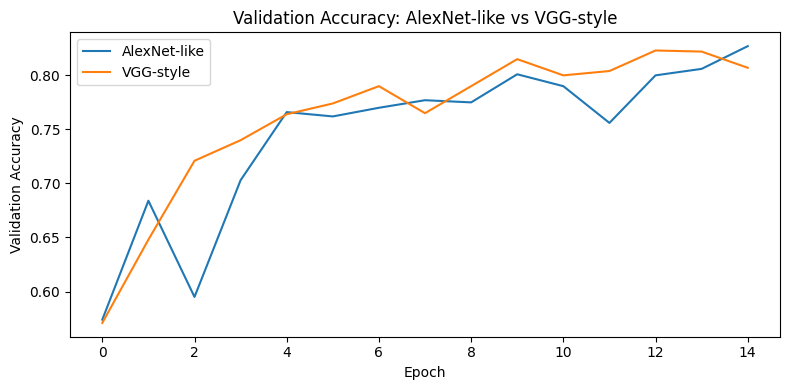

In [ ]:
# ============================================================
# Question Q6 — Final Evaluation, Parameter Count, and Plotting
# ============================================================
# Complete the TODO sections to:
#  1) Compute total trainable + non-trainable parameters from model.variables
#  2) Evaluate both models on the test set
#  3) Create a compact comparison summary
#  4) Plot validation accuracy curves for both models
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

def total_params(model):
    # TODO 1: Compute total number of parameters in a model
    # Hint: sum over np.prod(v.shape) for each variable v in model.variables
    return int(np.sum([np.prod(v.shape) for v in model.variables]))


# -------- Test Evaluation --------
# TODO 2: Evaluate AlexNet-like model on test_ds and extract accuracy (index 1)
alex_test_acc = float(alex_model.evaluate(test_ds, verbose=0)[1])

# TODO 3: Evaluate VGG-style model on test_ds and extract accuracy (index 1)
vgg_test_acc  = float(vgg_model.evaluate(test_ds, verbose=0)[1])


# -------- Build Summary Table --------
# TODO 4: Build a list of tuples: (name, test_acc, time_sec, params)
summary = [
    ("AlexNet", alex_test_acc, float(time_alex), total_params(alex_model)),
    ("VGG", vgg_test_acc,  float(time_vgg), total_params(vgg_model)),
]

print("Comparison (Test):")
for name, acc, tsec, params in summary:
    # TODO 5: Print formatted comparison line
    print(f"- {name:10s} | test_acc={acc:.4f} | time={tsec:.1f}s | params={params:,}")


# -------- Plot Validation Accuracy Curves --------
# TODO 6: Create figure
plt.figure(figsize=(8, 4))

# TODO 7: Plot AlexNet-like validation accuracy
plt.plot(hist_alex.history.get("val_accuracy", []), label="AlexNet-like")

# TODO 8: Plot VGG-style validation accuracy
plt.plot(hist_vgg.history.get("val_accuracy", []), label="VGG-style")

# TODO 9: Add x/y labels, legend, title
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title("Validation Accuracy: AlexNet-like vs VGG-style")

plt.tight_layout()
plt.show()


## Q7 — Regularization Mini-Experiment (One Controlled Change)

Choose one model and change **one thing**:
- Dropout 0.5 -> 0.3 or 0.6 OR
- Add small RandomCrop/Zoom (keep realistic)

Retrain and compare best val acc vs baseline.


In [ ]:
# ============================================================
# Question Q7 — Mini Experiment: Change Dropout (0.5 → 0.3)
# ============================================================
# Controlled experiment:
#   - Keep AlexNet-like architecture the same
#   - Change ONLY the dropout rate from 0.5 to 0.3
#
# Complete the TODO sections to:
#  1) Build a configurable AlexNet with dropout parameter "drop"
#  2) Train the modified model
#  3) Compare best validation accuracy vs the baseline AlexNet
#  4) Store results in a dictionary
# ============================================================


def build_alexnet_cifar_dropout(drop=0.5, input_shape=(32, 32, 3), num_classes=10):
    # TODO 1: Define input layer
    inputs = layers.Input(shape=input_shape)

    # -------- Block 1 --------
    x = layers.Conv2D(64, 5, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)          # BatchNorm
    x = layers.MaxPooling2D(2)(x)   # MaxPool

    # -------- Block 2 --------
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)          # BatchNorm
    x = layers.MaxPooling2D(2)(x)   # MaxPool

    # -------- Block 3 --------
    x = layers.Conv2D(192, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(192, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)

    # -------- Classifier --------
    x = layers.Flatten()(x)                           # Flatten
    x = layers.Dense(256, activation="relu")(x)

    # TODO 2: Use dropout rate given by parameter "drop"
    x = layers.Dropout(drop)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # TODO 3: Return a Keras model with a name that includes the dropout value
    return tf.keras.Model(inputs, outputs, name=f"AlexNet_CIFAR_Drop")


# TODO 4: Build the modified model with dropout = 0.3
alex_drop03 = build_alexnet_cifar_dropout(
    drop=0.3,
    input_shape=(32,32,3),
    num_classes=num_classes
)

# TODO 5: Compile the modified model (same settings as baseline)
alex_drop03.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss="SparseCategoricalCrossentropy",
    metrics=["accuracy"]
)

# TODO 6: Train and measure training time
t0 = time.time()
hist_alex_drop03 = alex_drop03.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=make_callbacks("alex_drop03")
)
time_alex_drop03 = time.time() - t0


# -------- Compare Results --------
# TODO 7: Compute best validation accuracy for baseline and modified models
baseline_best_val = float(np.max(hist_alex.history.get("val_accuracy", [np.nan])))
modified_best_val = float(np.max(hist_alex_drop03.history.get("val_accuracy", [np.nan])))

# TODO 8: Store mini-experiment results in a dictionary
mini_exp = {
    "baseline_alex_drop0.5": {
        "best_val_acc": baseline_best_val,
        "test_acc": float(time_alex)
    },
    "modified_alex_drop0.3": {
        "best_val_acc": modified_best_val,
        "train_time_sec": float(time_alex_drop03)
    },
}

print(mini_exp)


Epoch 1/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.3866 - loss: 1.7189 - val_accuracy: 0.6170 - val_loss: 1.0892 - learning_rate: 3.0000e-04
Epoch 2/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6253 - loss: 1.0649 - val_accuracy: 0.6920 - val_loss: 0.8861 - learning_rate: 3.0000e-04
Epoch 3/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7037 - loss: 0.8451 - val_accuracy: 0.7350 - val_loss: 0.7733 - learning_rate: 3.0000e-04
Epoch 4/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7605 - loss: 0.6914 - val_accuracy: 0.7540 - val_loss: 0.7661 - learning_rate: 3.0000e-04
Epoch 5/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7942 - loss: 0.5826 - val_accuracy: 0.7140 - val_loss: 0.8522 - learning_rate: 3.0000e-04
Epoch 6/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8315 - loss: 0.4870 - val_accuracy: 0.7780 - val_loss: 0.6826 - learning_rate: 3.0000e-04
Epoch 7/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - a

## Q8 — Qualitative Error Analysis (Fast, Visual)

Pick the best model and show 12 test images with:
- true label
- predicted label
- confidence


In [ ]:
total_params(alex_drop03)
#total_params(alex_model)

1422092

Best model: AlexNet


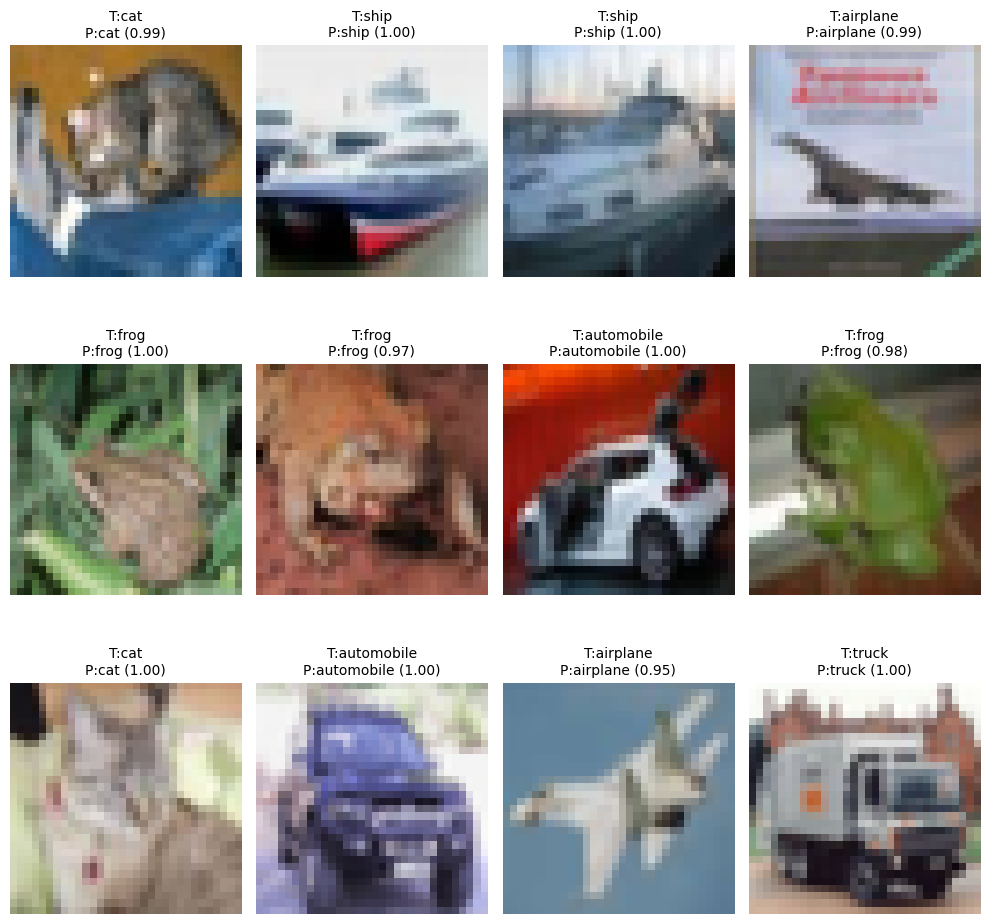

In [ ]:
# ============================================================
# Question Q8 — Select Best Model & Visualize Predictions
# ============================================================
# Complete the TODO sections to:
#  1) Select the best model based on test accuracy
#  2) Get a batch from the test dataset
#  3) Run prediction and compute predicted labels + confidences
#  4) Visualize 12 test images with True label, Pred label, and confidence
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# TODO 1: Choose the best model based on test accuracy
best_name, best_model = (
    ("AlexNet", alex_model) if alex_test_acc >= vgg_test_acc
    else ("VGG", vgg_model)
)

print("Best model:", best_name)

# TODO 2: Get one batch from the test dataset
x_batch, y_batch = next(iter(test_ds))

# TODO 3: Predict class probabilities for this batch
probs = best_model.predict(x_batch, verbose=0)

# TODO 4: Convert probabilities to predicted class labels
preds = np.argmax(probs, axis=1)

# TODO 5: Confidence = max probability per sample
confs = np.max(probs, axis=1)

# -------- Visualization --------
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(rows, col, i + 1)

    # TODO 6: Show image i from the batch
    plt.imshow(x_batch[i])

    # TODO 7: Get true and predicted class names
    t = class_names[int(y_batch[i])]
    p = class_names[int(preds[i])]

    # TODO 8: Title format: True label, Pred label, confidence (2 decimals)
    plt.title(f"T:{t}\nP:{p} ({confs[i]:.2f})", fontsize=10)

    # TODO 9: Hide axes
    plt.axis("off")

plt.tight_layout()
plt.show()


# Short Discussion (Answer Each Question Clearly)

- **Review and answer the following questions carefully briefly**

1) Why must AlexNet be **adapted** for 32×32 images (compared to ImageNet 224×224)?  
2) Which model is more efficient on CPU and why?  
3) What did your mini-experiment change and what did you observe?


### Q9. Why must AlexNet be adapted for 32×32 images (compared to ImageNet

---

In the original AlexNet paper, it took image input of 256x256x3 but processed it down to 224x224x3, which is much greater than our 32x32x3 image input. AlexNet must be adapted for 32x32 images as a key part of AlexNet is its downpooling of image size. This maxpooling of size usually starts at a much higher resolution than our 32x32 images used from CIFAR-10.

For maxpooling AlexNet starts off with a 3x3 downsampling with a stride of 2 to account for completion across different downsample steps. Our downsampling is limited by our small pool of pixel samples, which prevents us from doing this step so we are required to do a 2x2 downsampling with no account for consistency across each downsample.


---


### Q10. Which model is more efficient on CPU and why?


Based on Q6 results, the VGG-style model is more efficient on CPU because it has much fewer parameters (306,604 vs 1,422,092) and also trains faster (135.3s vs 150.7s [as time on GPU]). With fewer parameters, VGG requires less memory, which improves efficiency on CPU. From the validation accuracy curve, VGG shows relatively smooth while AlexNet-like fluctuates more in early epochs.

Although AlexNet-like achieved a slightly higher test accuracy (0.8125 vs 0.8054), VGG-style is more CPU efficient in terms of computation and training time in our experiment.


---


### Q11. What did your mini-experiment change and what did you observe?


In the mini-experiment, we changed the dropout rate for the AlexNet model from 0.5 to 0.3, which means we activated more neurons in the FC layers to handle more complex parameters and features. In data preprocessing, we applied light augmentation to the training data, which added more complex features to the dataset. As expected, we observed that the validation accuracy slightly increased by changing the dropout rate from 0.5 to 0.3 (0.827 to 0.830).


---


### 🎉 Congratulations!

You have successfully completed **A3-AlexNet-VGG**. Excellent work exploring and comparing **convolutional neural network architectures**, specifically **AlexNet** and **VGG16**, and analyzing how **depth, parameterization, and architectural design choices** affect performance on the **CIFAR-10 dataset** under **CPU-only training constraints**.

### **Submission Instructions**

Please submit a **GitHub repository link** on Canvas that contains:
- The **completed Jupyter notebook**
- Any additional files required for the assignment (if applicable)

Before submitting, ensure that:
- All **code cells (Q1–Q8)** have been executed successfully
- All **Markdown responses (Q9–Q11)** have been completed
- The notebook is **saved after execution** so that outputs are visible

Once verified, **push the final version to GitHub** and submit the repository link on Canvas.
